# Neural networks for front-car selection

This jupyter notebook demonstrates how to train a neural network to enable front-car selection.

![title](img/frontcar.jpg)

As can be observed by the above figure, the input for front-car selection contains two parts:

* Bounding boxes of vehicles obtained from object recognition (red rectangle in the figure)
* Lane information characterized by points or parameters (e.g., green triangle in the figure)

The output of the network shall indicate the vehicle in the front, e.g., the red vehicle being sourounded by a blue rectangle.

One should observe that designing such a front-car selection can be a nontrivial task, as things such as area covering is not working - the box of the truck actually intersects a larger area with the triangle. Therefore, in this project, we train a neural network to perform required tasks. 

In [84]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline



In [85]:
import numpy as np
import ast
import torch

# For repeatability
np.random.seed(42)

# Device configuration: Go for GPU if exsists
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The image being processed has size 1800x450

In [86]:
IMAGE_SIZE_X = 1800
IMAGE_SIZE_Y = 450
TARGET_LABEL_QUANTITY = 1

### Preparing the data

We now prepare a data processor for preparing data used in training. The input will be organized as a 2D numpy array with size being "(numberOfVehiclesBeingTracked + 1) x 4".

* For the first numberOfVehiclesBeingTracked elements, they are used to store bounding boxes. THerefore, this neural network only takes finitely many bounding boxes. 
* For the last element, it is used to store the 4 inputs of the lane detection algorithm.


![title](img/inputformat.jpg)


To have better performance, we want all data to be normalized to value between 0 and 1. Apart from dividing centerX with IMAGE_SIZE_X and dividing centerY with IMAGE_SIZE_Y, we have one additional processing step for normalizing the data, where we derive the largest bounding box size.

In [87]:
from torch.utils.data.dataset import Dataset

class TargetVehicleSelectionDataProcessor():
    
    numberOfVehiclesBeingTracked = 20
    numberOfOutputClasses = numberOfVehiclesBeingTracked + 1

    
    def __init__(self, vehicleFile, roadFile, targetVehicleFile):
        
        
        object_labels_file = open(vehicleFile, "r")

        maxQuantityBoxSize = 0
        filename = object_labels_file.readline()
    
        inputFeaturesList = []
        print("----- Read bounding box information to get max box (for normalization) -----")
        count = 0
        while filename:

            labels = ast.literal_eval(object_labels_file.readline())        

            # For the 1st axis, the items are object-exist(0,1), centerX, centerY, widthX, widthY
            for label in labels:
                if label[0] == "car" or label[0] == "truck":
                    widthX = label[2][2]
                    widthY = label[2][3]
                    if(maxQuantityBoxSize < widthX):
                        maxQuantityBoxSize = widthX
                    if(maxQuantityBoxSize < widthY):
                        maxQuantityBoxSize = widthY
            filename = object_labels_file.readline()
 

        print(maxQuantityBoxSize)
        print("----- Read road information to normalize coordinate (for normalization) -----")
        road_file = open(roadFile, "r")
       
        maxValue = [0,0,0,0,0,0,0]
        minValue = [IMAGE_SIZE_X, IMAGE_SIZE_X, IMAGE_SIZE_X, IMAGE_SIZE_X, IMAGE_SIZE_X, IMAGE_SIZE_X, IMAGE_SIZE_X]

        while True:
            road = road_file.readline()
            if road == '':
                break
            laneMarkings = road.replace(",", " ").split()
            for i in [1,3,4,5]:
                # print(laneMarkings)
                if(float(laneMarkings[i]) < minValue[i]):
                    minValue[i] = float(laneMarkings[i])
                if(float(laneMarkings[i]) > maxValue[i]):
                    maxValue[i] = float(laneMarkings[i])
        
        
        minValueLane = [minValue[1], minValue[3], minValue[4], minValue[5]]
        maxValueLane = [maxValue[1], maxValue[3], maxValue[4], maxValue[5]]
        intervalLane = [0,0,0,0]
        for i in range(4):
            intervalLane[i] = maxValueLane[i] - minValueLane[i]
        print(minValueLane)
        print(maxValueLane)
        print(intervalLane)
        
        road_file.close()
        

        print("----- Read bounding box information & road segmation & target vehicle info to create input data -----")       
        object_labels_file = open(vehicleFile, "r")
        target_file = open(targetVehicleFile, "r")                
        road_file = open(roadFile, "r")

        
        # First read the image name
        object_labels = object_labels_file.readline()
        target = target_file.readline()
        
        # To store numpy input features
        inputFeaturesList = []
        # To store target vehicle class
        FinalSelectedVehicleList = []
        
        count = 0
        while object_labels:

            labels = ast.literal_eval(object_labels_file.readline())
            laneMarkings = road_file.readline().replace(",", " ").split()
            if(count % 10000 == 0):
                print(count)
            count = count + 1
            
            # For the 1st axis, the items are object-exist(0,1), centerX, centerY, widthX, widthY
            inputLabel = np.zeros([self.numberOfVehiclesBeingTracked + 1, 4])
            centerXList = []
            centerYList = [] 
            
            vehicleCount = 0
            for label in labels:
                if label[0] == "car" or label[0] == "truck":
                    
                    centerX = label[2][0] 
                    centerY = label[2][1]
                    # Normalize the value to be the maximum quantity of the box size
                    widthX = label[2][2] / maxQuantityBoxSize
                    widthY = label[2][3] / maxQuantityBoxSize                 
                    # Normalize the value by dividing it with the pixel
                    centerX = centerX / IMAGE_SIZE_X
                    centerY = centerY / IMAGE_SIZE_Y
                    centerXList.append(centerX)
                    centerYList.append(centerY)
                    
                    inputLabel[vehicleCount][0] = centerX
                    inputLabel[vehicleCount][1] = centerY
                    inputLabel[vehicleCount][2] = widthX
                    inputLabel[vehicleCount][3] = widthY
                    
                    vehicleCount = vehicleCount +1
                    
            inputLabel[self.numberOfVehiclesBeingTracked][0] = (float(laneMarkings[1]) - minValueLane[0])/ intervalLane[0]
            inputLabel[self.numberOfVehiclesBeingTracked][1] = (float(laneMarkings[3]) - minValueLane[1])/ intervalLane[1]
            inputLabel[self.numberOfVehiclesBeingTracked][2] = (float(laneMarkings[4]) - minValueLane[2])/ intervalLane[2]
            inputLabel[self.numberOfVehiclesBeingTracked][3] = (float(laneMarkings[5]) - minValueLane[3])/ intervalLane[3]

                    
            inputFeaturesList.append(inputLabel)
            # Read again the image name, in order to move on to the next one. 
            object_labels = object_labels_file.readline()
            
            
            
            
            # Read the target file
            labels = ast.literal_eval(target_file.readline())                                 
            targetLabel = np.zeros([self.numberOfOutputClasses]) # for L1 loss

            
            hasTarget = False
            if not (len(labels) == 0):
                if labels[0] == "car" or labels[0] == "truck":
                    centerX = labels[2][0] / IMAGE_SIZE_X
                    centerY = labels[2][1] / IMAGE_SIZE_Y

                    hasFound = False
                    for i in range(len(centerXList)):
                        if(centerXList[i] == centerX and centerYList[i] == centerY):
                            targetLabel[i] = TARGET_LABEL_QUANTITY                    
                            hasFound = True
                            break
                            
                    hasTarget = True
           
            if hasTarget == False:
                targetLabel[self.numberOfOutputClasses - 1] = TARGET_LABEL_QUANTITY
                
            FinalSelectedVehicleList.append(targetLabel)
            
            # Read again the target file, in order to move on to the next one. 
            filename = target_file.readline()
            
            
            
        self.inputFeatures = np.dstack(inputFeaturesList)
        self.inputFeatures = np.rollaxis(self.inputFeatures,-1)
        self.inputFeatures = torch.from_numpy(np.float32(self.inputFeatures))
        
        
        self.labels = np.dstack(FinalSelectedVehicleList)
        self.labels = np.rollaxis(self.labels,-1)
        self.labels = torch.from_numpy(np.float32(np.squeeze(self.labels, axis=1)))
  
        object_labels_file.close()
        road_file.close()        
        target_file.close()           


        if not(self.inputFeatures.shape[0] == self.labels.shape[0]):
            raise Error("Size of target vehicles not the same as size of inputs")

    def __len__(self):
        return self.inputFeatures.shape[0] # of how many examples(images?) you have            
    
    def dumpDataToNpy(self, fileName):
        np.save(fileName, self.inputFeatures.numpy())
        
    def dumpLabelToNpy(self, fileName):
        np.save(fileName, self.labels.numpy())


If you do not have the .npy file available, please set the variable processRawData to True.

In [88]:
processRawData = False

if processRawData:
    dataset = TargetVehicleSelectionDataProcessor("data/frontcardetection/batch_results_sorted.txt", "data/frontcardetection/triangles_opencv_v8.txt", "data/frontcardetection/fw_label_sorted_v8.txt")
    dataset.dumpDataToNpy("data/frontcardetection/batch_results_processed_nogrid_v8.npy")
    dataset.dumpLabelToNpy("data/frontcardetection/fw_label_processed_nogrid_v8.npy")
    print("----- size of the data -----")
    print(len(dataset))
    

Then one can prepare dataset using the below class. The parameter "isL2Loss" is used to create output either as one hot encoding (as used in L1 loss) or as general numeric enocding (as used in L2 loss).

In [89]:
class TargetVehicleSelectionDataset(Dataset):
    
    inputFeatures = None
    labels = None
    
    def __init__(self, vehicleFileNpy, targetVehicleFileNpy, isL2Loss):     

        self.inputFeatures = torch.from_numpy(np.load(vehicleFileNpy))
        
        if isL2Loss:
            # Rewrite one-hot encoding back
            self.labels = torch.from_numpy(np.argmax(np.int64(np.load(targetVehicleFileNpy)), axis=1))
        else:
            self.labels = torch.from_numpy(np.load(targetVehicleFileNpy))
    
        
    def __getitem__(self, index):
        # stuff
        return (self.inputFeatures[index], self.labels[index])

    def __len__(self):
        return self.inputFeatures.shape[0] # of how many examples(images?) you have

In [90]:
dataset = TargetVehicleSelectionDataset("data/frontcardetection/batch_results_processed_nogrid_v8.npy", "data/frontcardetection/fw_label_processed_nogrid_v8.npy", True)
print(len(dataset))

123996


Here we prepare a simple ReLU network with 2 hidden layers.

In [91]:
import torch.nn as nn
import torch.nn.functional as F

numberOfVehiclesBeingTracked = 20
numberOfOutputClasses = numberOfVehiclesBeingTracked + 1


class NeuralNet(nn.Module):

    def __init__(self):
        super(NeuralNet, self).__init__()

        self.fc1 = nn.Linear((numberOfVehiclesBeingTracked+1)*4, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, numberOfOutputClasses)
        
    def forward(self, x):
        x = x.view(-1, (numberOfVehiclesBeingTracked+1)*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out 

    def forwardWithIntermediate(self, x):
        x = x.view(-1, (numberOfVehiclesBeingTracked+1)*4)
        x = F.relu(self.fc1(x))
        intermediateValues = F.relu(self.fc2(x))
        out = self.fc3(intermediateValues)
        return out, intermediateValues
  
    
net = NeuralNet()
net.eval()




NeuralNet(
  (fc1): Linear(in_features=84, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=21, bias=True)
)

Some parameters for training.

In [92]:
# Loss and optimizer
learning_rate = 0.001
batch_size = 2048
num_epochs = 40

# weight_decay as parameter to be tuned 0, 0.001, 0.01
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.0001)  

Load the parameter from a pre-trained network (the network is not trained with very high correctness rate; you may further train it)

In [93]:
net.load_state_dict(torch.load('models/model_front_car_100x50.ckpt'))

We resere 5% for validation set (for hyper parameter tuning), 5% for test set (never touch it), and 90% for training. The data is shuffled then distributed, 

In [94]:
from torch.utils.data.sampler import SubsetRandomSampler

test_size = 0.05

num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(test_size * num_train))

np.random.shuffle(indices)

train_idx, valid_idx, test_idx = indices[(2*split):], indices[split:(2*split)], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)



Now, load the training, validation, and test set based on the sampler. 

In [95]:
train_loader = torch.utils.data.DataLoader(dataset=dataset, sampler=train_sampler,
                                           batch_size=batch_size)

valid_loader = torch.utils.data.DataLoader(dataset=dataset, sampler=valid_sampler,
                                           batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(dataset=dataset, sampler=test_sampler,
                                          batch_size=batch_size)

If you want to train the network, change the variable "furtherTrain" to True.

In [96]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

furtherTrain = False

if furtherTrain: 
    # Train the model
    total_step = len(train_loader)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = net(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            
            if batch_size > 5000:
                if (i+1) % 4 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))    
            elif batch_size > 1000:
                if (i+1) % 10 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))           
            else: 
                if (i+1) % 1000 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))              


In [97]:
# In test phase, we don't need to compute gradients (for memory efficiency)

isL2Loss = True

with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        #print(images[0])
        outputs = net(images)
        _, predictedY = torch.max(outputs.data, 1)
        
        correctLabelsY = None        
        if(isL2Loss):
            # L2 (without one-hot encoding)
            correctLabelsY = labels.data            
        else:
            # L1 (with one-hot encoding)
            _, correctLabelsY = torch.max(labels.data, 1)

        
        total += labels.size(0)
        
        # print(labels.numpy().shape)
        correct += (predictedY == correctLabelsY).sum().item()
        

    print('Accuracy of the network on the training set: {} %'.format(100 * correct / total))
     
with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = net(images)
        _, predictedY = torch.max(outputs.data, 1)
        
        correctLabelsY = None        
        if(isL2Loss):
            # L2 (without one-hot encoding)
            correctLabelsY = labels.data            
        else:
            # L1 (with one-hot encoding)
            _, correctLabelsY = torch.max(labels.data, 1)
        
        total += labels.size(0)
        
        # print(labels.numpy().shape)
        correct += (predictedY == correctLabelsY).sum().item()
        

    print('Accuracy of the network on the validation set: {} %'.format(100 * correct / total))
    

Accuracy of the network on the training set: 86.50603057402462 %
Accuracy of the network on the validation set: 86.33650588804646 %


Save the trained model

In [98]:
#torch.save(net.state_dict(), 'models/model_front_car_100x100x50.ckpt')

## Test the front-car selection network on images

Here we provide two utility functions 
* derivePredictedFrontCar() for deriving the index of the bounding box to be front car
* drawFrontCar() for drawing the front car in the image

In [99]:
def derivePredictedFrontCar(boundingBoxList, laneDetectionInfo):
    '''
    Derive which box is the front vehicle. 
    
    Args:
    boundingBoxList -- a list of bounding boxes (represented as an array [centerX, centerY, sizeX, sizeY]) representing vehicles (other objects such as signs shall be removed)
    laneDetectionInfo -- a list of 4 inputs [x1, x2, y2, x3]
    
    Returns:
    int: index of boundingBoxList if one of them is a predicted front car, -1 if no car is detected
    '''
    
    # Parameters here are derived by analyzing the data
    maxQuantityBoxSize = 1984.615966796875
    minValueLane = [268.0, 708.0, 7.0, 954.0]
    intervalLane = [569.0, 409.0, 292.0, 602.0]
    numberOfVehiclesBeingTracked = 20
    numberOfOutputClasses = numberOfVehiclesBeingTracked + 1    
    
    inputLabel = np.zeros([numberOfVehiclesBeingTracked + 1, 4])
    
    vehicleCount = 0
    for boundingBox in boundingBoxList:
        centerX = boundingBox[0] 
        centerY = boundingBox[1]
        # Normalize the value to be the maximum quantity of the box size
        widthX = boundingBox[2] / maxQuantityBoxSize
        widthY = boundingBox[3] / maxQuantityBoxSize                 

        
        # Normalize the value by dividing it with the pixel
        centerX = centerX / IMAGE_SIZE_X
        centerY = centerY / IMAGE_SIZE_Y

        inputLabel[vehicleCount][0] = centerX
        inputLabel[vehicleCount][1] = centerY
        inputLabel[vehicleCount][2] = widthX
        inputLabel[vehicleCount][3] = widthY
        vehicleCount = vehicleCount + 1
        inputLabel[numberOfVehiclesBeingTracked][0] = (float(laneDetectionInfo[0]) - minValueLane[0])/ intervalLane[0]
        inputLabel[numberOfVehiclesBeingTracked][1] = (float(laneDetectionInfo[1]) - minValueLane[1])/ intervalLane[1]
        inputLabel[numberOfVehiclesBeingTracked][2] = (float(laneDetectionInfo[2]) - minValueLane[2])/ intervalLane[2]
        inputLabel[numberOfVehiclesBeingTracked][3] = (float(laneDetectionInfo[3]) - minValueLane[3])/ intervalLane[3]
        

    inputs = []
    inputs.append(inputLabel)         
    inputs = np.dstack(inputs)
    inputs = np.rollaxis(inputs,-1)
    inputs = torch.from_numpy(np.float32(inputs))

    with torch.no_grad():
        
        # print(inputs[0])
        
        inputs = inputs.to(device)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)    

        output = predicted.numpy()[0]
        
        if(output == numberOfOutputClasses - 1):
            print("network says that no front car")
            return -1
        else:
            return output


drawFrontCar() is within util.py

In [100]:
import util

#### A. Image frames0023291.jpg

(1) Input from the bounding box

[('car', 0.9984562397003174, (576.3399047851562, 316.2917785644531, 286.28106689453125, 186.20248413085938)), 
('car', 0.9743680953979492, (127.26703643798828, 286.13848876953125, 252.41139221191406, 164.10342407226562)), 
('car', 0.8326014876365662, (781.6996459960938, 238.186279296875, 42.52123260498047, 26.923107147216797)), 
('car', 0.8239439129829407, (845.2855834960938, 235.84620666503906, 41.73268127441406, 35.90092468261719)), 
('car', 0.6865452527999878, (975.0291137695312, 240.38128662109375, 67.97051239013672, 43.96461868286133)), 
('car', 0.6862249374389648, (699.9054565429688, 240.95892333984375, 52.11764907836914, 34.9674186706543)), 
('car', 0.5572288036346436, (888.8295288085938, 233.42330932617188, 25.159809112548828, 25.35500144958496))]

(2) Input from the lane info: (frames0023291: 297,450 844,189 1203,450)


(3) Correct result of frames0023291.jpg (as ground truth):
('car', 0.9984562397003174, (576.3399047851562, 316.2917785644531, 286.28106689453125, 186.20248413085938))


<!--- ![title](img/sequence/test/frames0023291.jpg) -->

In [101]:
boundingBoxList=[[576.3399047851562, 316.2917785644531, 286.28106689453125, 186.20248413085938], 
                [127.26703643798828, 286.13848876953125, 252.41139221191406, 164.10342407226562],
                [781.6996459960938, 238.186279296875, 42.52123260498047, 26.923107147216797],
                [845.2855834960938, 235.84620666503906, 41.73268127441406, 35.90092468261719],
                [975.0291137695312, 240.38128662109375, 67.97051239013672, 43.96461868286133],
                [699.9054565429688, 240.95892333984375, 52.11764907836914, 34.9674186706543],
                [888.8295288085938, 233.42330932617188, 25.159809112548828, 25.35500144958496]]

laneDetectionInfo=[297,844,189, 1203]

In [102]:
index = derivePredictedFrontCar(boundingBoxList, laneDetectionInfo)

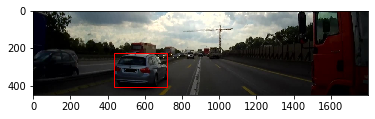

In [103]:
if index != -1:
    util.drawFrontCar('img/sequence/test/frames0023291.jpg', boundingBoxList[index])

#### B. Image frames0060931.jpg

(1) Input from the bounding box

[('truck', 0.9686129093170166, (664.022216796875, 176.36538696289062, 238.4475555419922, 192.21405029296875)), 
('truck', 0.8795585036277771, (1045.208251953125, 200.95474243164062, 127.88365173339844, 149.4367218017578)), 
('car', 0.8282604217529297, (881.839111328125, 175.23509216308594, 29.620193481445312, 24.062349319458008)), 
('car', 0.7414387464523315, (806.3452758789062, 178.2257080078125, 46.19411849975586, 32.87610626220703)), 
('car', 0.6790100336074829, (916.25244140625, 170.0439453125, 17.430356979370117, 15.947772979736328))]

(2) Input from the lane info: (frames0060931: 469,450 933,171 1195,450)

(3) Correct result of frames0060931.jpg:
('car', 0.6790100336074829, (916.25244140625, 170.0439453125, 17.430356979370117, 15.947772979736328))


<!---  ![title](img/sequence/test/frames0060931.jpg) -->

In [104]:

boundingBoxList=[[664.022216796875, 176.36538696289062, 238.4475555419922, 192.21405029296875], 
                [1045.208251953125, 200.95474243164062, 127.88365173339844, 149.4367218017578],
                [881.839111328125, 175.23509216308594, 29.620193481445312, 24.062349319458008],
                [806.3452758789062, 178.2257080078125, 46.19411849975586, 32.87610626220703],
                [916.25244140625, 170.0439453125, 17.430356979370117, 15.947772979736328]]

laneDetectionInfo=[469,933,171, 1195]

In [105]:
index = derivePredictedFrontCar(boundingBoxList, laneDetectionInfo)

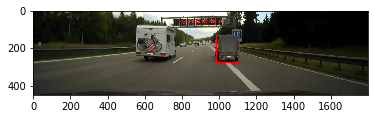

In [106]:
if index != -1:
    util.drawFrontCar('img/sequence/test/frames0060931.jpg', boundingBoxList[index])

#### C. Image frames0061374.jpg

(1) Input from the bounding box

[('truck', 0.7765164971351624, (912.59716796875, 162.4954071044922, 73.30638885498047, 82.89049530029297)), 
('car', 0.5375076532363892, (819.02392578125, 178.01235961914062, 35.7996940612793, 28.5452823638916))]


(2) Input from the lane info: (frames0061374: 471,916,165, 1216)


(3) Correct result of frames0061374.jpg:
('truck', 0.7765164971351624, (912.59716796875, 162.4954071044922, 73.30638885498047, 82.89049530029297))

<!--- ![title](img/sequence/test/frames0061374.jpg) -->

In [107]:
boundingBoxList=[[912.59716796875, 162.4954071044922, 73.30638885498047, 82.89049530029297], 
                [819.02392578125, 178.01235961914062, 35.7996940612793, 28.5452823638916]]

laneDetectionInfo=[471,916,165, 1216]

In [108]:
index = derivePredictedFrontCar(boundingBoxList, laneDetectionInfo)

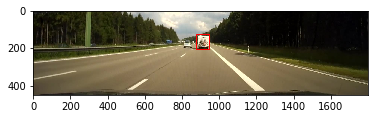

In [109]:
if index != -1:
    util.drawFrontCar('img/sequence/test/frames0061374.jpg', boundingBoxList[index])

# Formal verification

To run formal verification, it is required to install pulp (https://github.com/coin-or/pulp), which contains CBC MILP solver binding. The installation is simple: 

```sh
$ pip install pulp
``` 


In [30]:
pip install pulp


Note: you may need to restart the kernel to use updated packages.


ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "C:\Users\Shoaib\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _dep_map
    return self.__dep_map
  File "C:\Users\Shoaib\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2806, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Shoaib\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3003, in _parsed_pkg_info
    return self._pkg_info
  File "C:\Users\Shoaib\Anaconda3\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2806, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Shoaib\Anaconda3\lib\site-packages\pip\_

In [110]:
for name, param in net.named_parameters():
    print(name)
    print(param.shape)


fc1.weight
torch.Size([100, 84])
fc1.bias
torch.Size([100])
fc2.weight
torch.Size([50, 100])
fc2.bias
torch.Size([50])
fc3.weight
torch.Size([21, 50])
fc3.bias
torch.Size([21])


In [111]:
net.eval()

NeuralNet(
  (fc1): Linear(in_features=84, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=21, bias=True)
)

### A. Dataflow analysis (with box domain)

Now we trigger dataflow analysis (i.e., abstract interpretation with box abstraction), which computes a sound [min.max] value for each neuron output, based on the assumption that the input is bounded. 

In [112]:
from nndependability.formal import staticanalysis 

For all of our data, as we have them normalized, the input is within [0, 1]

In [113]:
inputMinBound = np.zeros((numberOfVehiclesBeingTracked+1)*4)
inputMaxBound = np.ones((numberOfVehiclesBeingTracked+1)*4)

In [114]:
# Dummy constraints: if risk property is not specified, then the verified result is the bound of each output neuron. 
#inputConstraints = []
#riskProperty = []

The risk property we want to avoid is the following: 

* If the  x<sub>i</sub>-th box is empty (placed inside inputConstraints), 
* Then the output of the network is  x<sub>i</sub> (i.e.,  x<sub>i</sub> >  x<sub>j</sub>, for all j != i) - to be placed in riskProperty



Let's take input i = 18, then the in72, in72, in74, in75 (the associated input related to the 18-th box) shall be set to 0 in the input constraint

In [115]:
inputConstraints = [[0, "==", 1, "in72"], [0, "==", 1, "in73"], [0, "==", 1, "in74"], [0, "==", 1, "in75"]]

In [116]:
riskProperty  = [[0, "<=", 1, "out18", -1, "out0"], [0, "<=", 1, "out18", -1, "out1"], [0, "<=", 1, "out18", -1, "out2"],
                 [0, "<=", 1, "out18", -1, "out3"], [0, "<=", 1, "out18", -1, "out4"],  [0, "<=", 1, "out18", -1, "out5"], [0, "<=", 1, "out18", -1, "out6"],
                 [0, "<=", 1, "out18", -1, "out7"], [0, "<=", 1, "out18", -1, "out8"], [0, "<=", 1, "out18", -1, "out9"],
                [0, "<=", 1, "out18", -1, "out10"], [0, "<=", 1, "out18", -1, "out11"], [0, "<=", 1, "out18", -1, "out12"],
                [0, "<=", 1, "out18", -1, "out13"], [0, "<=", 1, "out18", -1, "out14"], [0, "<=", 1, "out18", -1, "out15"],
                 [0, "<=", 1, "out18", -1, "out16"], [0, "<=", 1, "out18", -1, "out17"],
                 [0, "<=", 1, "out18", -1, "out19"], [0, "<=", 1, "out18", -1, "out20"]
                ]

We now perform static analysis using boxed domain, and the result indicates that the risk property is never reached, meaning that the network will never output 18 if there is no vehicle in the 18th input.

In [117]:
minBound, maxBound = staticanalysis.verify(inputMinBound, inputMaxBound, net, True, inputConstraints, riskProperty)



Processing layer fc1
Processing layer fc2
Processing layer fc3
Finish checking - dimension OK!
[Boxed abstraction] Processing layer 1
[Boxed abstraction] Processing layer 2
[Boxed abstraction] Processing layer 3
Solver Status: Infeasible
Risk property is not reachable (using boxed abstraction)


% [If we change the property to be the 5-th car, static analysis is not able to prove it] Let's take input i = 5, then the in20, in21, in22, in23 (the associated input related to the 5-th box) shall be set to 0 in the input constraint %

In [118]:
# inputConstraints = [[0, "==", 1, "in20"], [0, "==", 1, "in21"], [0, "==", 1, "in22"], [0, "==", 1, "in23"]]

In [119]:
# riskProperty  = [[0, "<=", 1, "out5", -1, "out0"], [0, "<=", 1, "out5", -1, "out1"], [0, "<=", 1, "out5", -1, "out2"],
#                 [0, "<=", 1, "out5", -1, "out3"], [0, "<=", 1, "out5", -1, "out4"],   [0, "<=", 1, "out5", -1, "out6"],
#                 [0, "<=", 1, "out5", -1, "out7"], [0, "<=", 1, "out5", -1, "out8"], [0, "<=", 1, "out5", -1, "out9"],
#                [0, "<=", 1, "out5", -1, "out10"], [0, "<=", 1, "out5", -1, "out11"], [0, "<=", 1, "out5", -1, "out12"],
#                [0, "<=", 1, "out5", -1, "out13"], [0, "<=", 1, "out5", -1, "out14"], [0, "<=", 1, "out5", -1, "out15"],
#                 [0, "<=", 1, "out5", -1, "out16"], [0, "<=", 1, "out5", -1, "out17"],[0, "<=", 1, "out5", -1, "out18"],
#                 [0, "<=", 1, "out5", -1, "out19"], [0, "<=", 1, "out5", -1, "out20"]
#                ]

### B. Dataflow analysis (with octagon domain)

After we perform dataflow analysis over the box domain, we can further do analysis on the octagon domain. In the octagon domain, one additionally keeps the min and max value of x<sub>i</sub> - x<sub>j</sub>. Therefore, if there are n neurons in the layer, there will be n(n-1)/2 such entries, meaning that MILP shall be triggered in frequency square to the number of neurons in a layer.  


#### B.1. Boxed abstraction

Here we set inputConstraint and riskProperty to be [], so the dataflow analysis proceeds by taking each input having bound [0,1]

In [120]:
minBound, maxBound = staticanalysis.verify(inputMinBound, inputMaxBound, net, True, [], [])

print("===== Output bound based on boxed abstraction =====")
print("Min:")
print(minBound)
print("Max:")
print(maxBound)

Processing layer fc1
Processing layer fc2
Processing layer fc3
Finish checking - dimension OK!
[Boxed abstraction] Processing layer 1
[Boxed abstraction] Processing layer 2
[Boxed abstraction] Processing layer 3
Completed


===== Output bound based on boxed abstraction =====
Min:
[-1563.4999  -1707.9703  -1713.6078  -1980.218   -1830.6539  -1909.2358
 -1278.1092  -1150.1565  -1065.8956   -997.59144 -1037.0093  -1094.9352
 -1035.574    -838.6566   -917.64815 -1462.4441   -785.04317  -753.28498
  -754.27554  -755.64944  -821.70711]
Max:
[ 1.6862971e+03  1.3892462e+03  1.4749856e+03  1.4013786e+03
  1.4221402e+03  1.2680475e+03  1.3060952e+03  1.0259966e+03
  9.8205287e+02  9.5513606e+02  8.9818960e+02  8.4985136e+02
  8.7002469e+02  6.3859054e+02  6.6240884e+02  5.0587812e+02
  5.7773743e-01 -1.0664523e-01 -1.0624313e-01 -1.0576606e-01
  1.0657762e+03]


#### B.2: Octagon abstraction 
We run dataflow analysis with this time adding octagon constraints
* One may trigger full octagon abstraction (do it with caution - it may take very long time), or
* Only add a couple of octagon constraints (such as x<sub>i</sub> - x<sub>i+1</sub>).

Our static analysis engine provides both capabilities. 

In [121]:

# The 4th parameter "False" is set for enabling octagon abstraction, the last parameter "True" is to avoid having 2*N^2 constraints (set to "False" if you want the full octagon)
minBoundOctagon, maxBoundOctagon = staticanalysis.verify(inputMinBound, inputMaxBound, net, False, [], [], True)

Processing layer fc1
Processing layer fc2
Processing layer fc3
Finish checking - dimension OK!
[Boxed abstraction] Processing layer 1
[Boxed abstraction] Processing layer 2
[Boxed abstraction] Processing layer 3
bigM under abs(max bound): 1686.2971
bigM under abs(min bound): 1980.218
[Octagon abstraction] Processing layer 1
  (constraint shape x_{i} - x_{i+1}: 
  (constraint shape x_{i} + x_{i+1}: 0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,
  (constraint shape x_{i} - x_{i+(N/2)}: 
  (constraint shape x_{i} + x_{i+(N/2)}: 0,5,10,15,20,25,30,35,40,45,
Layer 1: completed

[Octagon abstraction] Processing layer 2
  (constraint shape x_{i}: 0,5,10,15,20,25,30,35,40,45,
  (constraint shape x_{i} - x_{i+1}: 
  (constraint shape x_{i} + x_{i+1}: 0,5,10,15,20,25,30,35,40,45,
  (constraint shape x_{i} - x_{i+(N/2)}: 
  (constraint shape x_{i} + x_{i+(N/2)}: 0,5,10,15,20,
Layer 2: completed


[Octagon abstraction] Processing layer 3
3  0
3  1
3  2
3  3
3  4
3  5
3  6
3  7
3  8
3  

In [83]:
pip install glpk


  Using cached https://files.pythonhosted.org/packages/ca/26/198ec4b9d1b752404a7ecb104bd1b4bfba711feaadabc0b1407de87adb26/glpk-0.4.6.tar.gz
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Running setup.py clean for glpk
Failed to build glpk
Note: you may need to restart the kernel to use updated packages.


  ERROR: Command errored out with exit status 1:
   command: 'C:\Users\Shoaib\Anaconda3\python.exe' 'C:\Users\Shoaib\Anaconda3\lib\site-packages\pip\_vendor\pep517\_in_process.py' build_wheel 'C:\Users\Shoaib\AppData\Local\Temp\tmph49z2he0'
       cwd: C:\Users\Shoaib\AppData\Local\Temp\pip-install-itdh_bwt\glpk
  Complete output (5 lines):
  running bdist_wheel
  running build
  running build_ext
  building 'glpk' extension
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
  ----------------------------------------
  ERROR: Failed building wheel for glpk
ERROR: Could not build wheels for glpk which use PEP 517 and cannot be installed directly


In [122]:
print("===== Output bound based on octagon abstraction =====")
print("Min:")
print(minBoundOctagon)
print("Max:")
print(maxBoundOctagon)

===== Output bound based on octagon abstraction =====
Min:
[-1321.619   -1340.0789  -1455.5372  -1593.1739  -1403.7027  -1643.1728
  -933.32152  -852.42947  -848.09866  -760.04674  -736.08889  -831.60353
  -792.00362  -634.75371  -662.39636 -1185.0574   -633.58989  -506.7361
  -507.91489  -509.4105   -627.46405]
Max:
[ 1.2119738e+03  1.1475963e+03  1.2408317e+03  1.0979704e+03
  1.1507137e+03  1.0119559e+03  1.0048826e+03  7.8704796e+02
  7.3942195e+02  7.3193776e+02  6.3029595e+02  6.2148313e+02
  6.4642588e+02  4.9771467e+02  4.8974114e+02  4.1986369e+02
  4.3145459e-01 -1.0664523e-01 -1.0624313e-01 -1.0576606e-01
  7.9716023e+02]


In [123]:
# minBound, maxBound = staticanalysis.verify(inputMinBound, inputMaxBound, net, False, inputConstraints, riskProperty, True)

We can observe that by adding octagon constraints, the output bound is indeed more precise (every value in the octagon abstraction is smaller than boxed abstraction).

# Runtime monitoring

For details on runtime monitoring, check other notebooks.  

In [124]:
performRV = False

if performRV: 
    from nndependability.rv import napmonitor

    num_classes = 21
    sizeOfNeuronsToMonitor = 50

    monitor = napmonitor.NAP_Monitor(num_classes, sizeOfNeuronsToMonitor)

In [125]:
if performRV: 
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            labels = labels.to(device)
            outputs, intermediateValues = net.forwardWithIntermediate(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Add the batch of neuron activation patterns to the monitor
            monitor.addAllNeuronPatternsToClass(intermediateValues.numpy(), predicted.numpy(), labels.numpy(), -1)


        print('Accuracy of the network on the all training data: {} %'.format(100 * correct / total))

In [126]:
if performRV: 
    # We don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        correct = 0
        outofActivationPattern = 0
        outofActivationPatternAndResultWrong = 0

        total = 0
        for images, labels in valid_loader:
            labels = labels.to(device)
            outputs, intermediateValues = net.forwardWithIntermediate(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Additional processing for runtime monitoring

            predictedNp = predicted.numpy()

            result = (predicted == labels)
            res = result.numpy()

            # Iterate over each image in the batch
            for exampleIndex in range(intermediateValues.shape[0]):   
                if not monitor.isPatternContained(intermediateValues.numpy()[exampleIndex,:], predicted.numpy()[exampleIndex]):
                    outofActivationPattern = outofActivationPattern +1
                    if res[exampleIndex] == False :
                        outofActivationPatternAndResultWrong = outofActivationPatternAndResultWrong + 1

        print('Accuracy of the network on the validation set: {} %'.format(100 * correct / total))
        print('Out-of-activation pattern on the validation set: {} %'.format(100 * outofActivationPattern / total))
        print('Out-of-activation pattern & misclassified / out-of-activation pattern : {} %'.format(100 * outofActivationPatternAndResultWrong / (outofActivationPattern)))


We see that out-of-activation patterns are small. This is because the abstraction used by 50 neurons are not sufficient. The mediation shall be to monitor more neurons. In some of our other non-public versions where we use more neurons in each layer with different architecture (e.g., batch norm is used), we are able to have the metric being significantly larger. 

Anyway, below we try the enlarging technique by running the API. Not surprisingly, the out-of-activation pattern will drop.  

monitor.enlargeSetByOneBitFluctuation(-1)

In [127]:
if performRV: 
    # We don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        correct = 0
        outofActivationPattern = 0
        outofActivationPatternAndResultWrong = 0

        total = 0
        for images, labels in valid_loader:
            labels = labels.to(device)
            outputs, intermediateValues = net.forwardWithIntermediate(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Additional processing for runtime monitoring

            predictedNp = predicted.numpy()

            result = (predicted == labels)
            res = result.numpy()

            # Iterate over each image in the batch
            for exampleIndex in range(intermediateValues.shape[0]):   
                if not monitor.isPatternContained(intermediateValues.numpy()[exampleIndex,:], predicted.numpy()[exampleIndex]):
                    outofActivationPattern = outofActivationPattern +1
                    if res[exampleIndex] == False :
                        outofActivationPatternAndResultWrong = outofActivationPatternAndResultWrong + 1

        print('Accuracy of the network on the validation set: {} %'.format(100 * correct / total))
        print('Out-of-activation pattern on the validation set: {} %'.format(100 * outofActivationPattern / total))
        print('Out-of-activation pattern & misclassified / out-of-activation pattern : {} %'.format(100 * outofActivationPatternAndResultWrong / (outofActivationPattern)))


Let's also try it on the test set, to see what are the results

In [128]:
if performRV: 
    # We don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        correct = 0
        outofActivationPattern = 0
        outofActivationPatternAndResultWrong = 0

        total = 0
        for images, labels in test_loader:
            labels = labels.to(device)
            outputs, intermediateValues = net.forwardWithIntermediate(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Additional processing for runtime monitoring

            predictedNp = predicted.numpy()

            result = (predicted == labels)
            res = result.numpy()

            # Iterate over each image in the batch
            for exampleIndex in range(intermediateValues.shape[0]):   
                if not monitor.isPatternContained(intermediateValues.numpy()[exampleIndex,:], predicted.numpy()[exampleIndex]):
                    outofActivationPattern = outofActivationPattern +1
                    if res[exampleIndex] == False :
                        outofActivationPatternAndResultWrong = outofActivationPatternAndResultWrong + 1

        print('Accuracy of the network on the test set: {} %'.format(100 * correct / total))
        print('Out-of-activation pattern on the test set: {} %'.format(100 * outofActivationPattern / total))
        print('Out-of-activation pattern & misclassified / out-of-activation pattern : {} %'.format(100 * outofActivationPatternAndResultWrong / (outofActivationPattern)))
